In [1]:
from itertools import combinations
from typing import Dict, List, Tuple
from concurrent.futures import ProcessPoolExecutor, as_completed
from pprint import pprint
import math
from tqdm import tqdm
from IPython.display import Markdown, display

CM = float
KG = float

# Define the Good class
class Good:
    def __init__(self, name: str, weight: KG, height: CM, length: CM, width: CM, num_good_in_package: int = 1):
        """
        Unless specified in `num_good_in_package`, each good is considered as a single good in a package
        """
        self.name = name
        self.weight = weight
        self.height = height
        self.length = length
        self.width = width
        self.num_good_in_package = num_good_in_package
        # weight is the max of actual weight and volume weight
        self.final_weight = max(self.weight, self.height * self.length * self.width / 6000)
    
    def __str__(self):
        return f"{self.name}"
    def __repr__(self):
        return str(self)
    def __len__(self):
        return self.num_good_in_package
    def __eq__(self, other):
        if not isinstance(other, Good):
            return False
        return (self.name == other.name and 
                self.weight == other.weight and 
                self.height == other.height and 
                self.length == other.length and 
                self.width == other.width)
    def __hash__(self):
        return hash((self.name, self.weight, self.height, self.length, self.width))

class GoodList(list):
    def pprint(self):
        """
        print the name and final weight of each good
        Sorted by final weight
        """
        print("-" * 50)
        print(f"Total {self.num_individal_goods} goods in {len(self)} packages, weight {self.total_final_weight} (actual weight {sum(g.weight for g in self)})")
        for good in sorted(self, key=lambda x: x.final_weight):
            print(f"{good.name}: {good.final_weight:.2f}kg")
        print("-" * 50)
    @property
    def total_final_weight(self) -> KG:
        return sum(g.final_weight for g in self)
    def __repr__(self):
        return str(self)
    def __str__(self):
        return "[" + ", ".join(good.name for good in self) + "]"
    @property
    def num_individal_goods(self) -> int:
        """
        Since sometimes a Good is in fact a package of multiple goods, need to sum up all the lengths
        """
        return sum(len(good) for good in self)

# cainiao's price computation

In [3]:
def calculate_price(weight: KG, first_kg_price=58, additional_kg_price=18, above_21_5_kg_price=20):
    """
    Calculate the price based on the given weight in kg.
    """
    if weight < 0 or weight > 65:
        raise ValueError("Weight must be between 0 and 65 kg.")
    
    if weight <= 1:
        return first_kg_price

    # 四舍五入到0.5或.0
    # eg 1.3 -> 1.5; 4.7 -> 5
    weight = math.ceil(weight * 2) / 2

    if weight <= 21.5:
        # First kg is 58, remaining weight is charged at 18/kg
        return first_kg_price + (weight - 1) * additional_kg_price

    # For weights above 21.5kg
    return weight * above_21_5_kg_price

def discount新用户(weight: KG):
    if weight <= 1:
        return 1
    return calculate_price(weight)

"""
2024 双十一优惠
"""
def discount首重(weight: KG):
    price = calculate_price(weight)
    if price >= 67:
        return price - 66
    return price
def discount34_off(weight: KG):
    """
    Discount 34% off, but at most discount 300
    """
    price = calculate_price(weight)
    discount = min(price * 0.34, 300)
    return price - discount
def discount10_off(weight: KG):
    """
    Discount 10% off, but at most discount 40
    """
    price = calculate_price(weight)
    discount = min(price * 0.1, 40)
    return price - discount
def discount满300减40(weight: KG):
    price = calculate_price(weight)
    if price >= 300:
        return price - 40
    return price
def discount满500减80(weight: KG):
    price = calculate_price(weight)
    if price >= 500:
        return price - 80
    return price
def discount满200减20(weight: KG):
    price = calculate_price(weight)
    if price >= 200:
        return price - 20
    return price
def discount满200减30(weight: KG):
    price = calculate_price(weight)
    if price >= 200:
        return price - 30
    return price
def discount无门槛15(weight: KG):
    price = calculate_price(weight)
    return price - 15
def discount无门槛20(weight: KG):
    price = calculate_price(weight)
    return price - 20
def discount无门槛50(weight: KG):
    price = calculate_price(weight)
    return price - 50
"""
2024 圣诞优惠
"""
def discount满108减66(weight: KG):
    price = calculate_price(weight)
    if price >= 108:
        return price - 66
    return price

discount_functions = {
    "首重": discount首重,
    "34off": discount34_off,
    "10off": discount10_off,
    "满300减40": discount满300减40,
    "满200减30": discount满200减30,
    "满200减20": discount满200减20,
    "满500减80": discount满500减80,
    "满108减66": discount满108减66,
    "无门槛15": discount无门槛15,
    "无门槛20": discount无门槛20,
    "无门槛50": discount无门槛50,
    "新用户": discount新用户,
}


from pytablewriter import MarkdownTableWriter

def price_stat(weights: List[KG], discounts: List[str] = None):
    """
    Create a string table with columns: weight, price w/o discount, unit price after 首重discount, unit price after 34% off
    There are len(weights) rows, and for price columns, show the price and unit price in parentheses
    """
    # Prepare data
    if discounts is None:
        discounts = []
    headers = ["Weight (kg)", "Price",]
    headers += [f"Price ({d} discount)" for d in discounts]
    headers += ["Best Price"]
    rows = []
    for weight in sorted(weights):
        price = calculate_price(weight)
        prices = [price]
        for d in discounts:
            prices.append(discount_functions[d](weight))
        best_price = min(prices)
        row = [
            f"{weight:.3f}",
        ]
        for p in prices:
            row.append(f"{p:.2f} ({p/weight:.2f}/kg)")
        row.append(f"{best_price:.2f} ({best_price/weight:.2f}/kg)")
        rows.append(row)
    
    # Create and write table
    writer = MarkdownTableWriter(
        headers=headers,
        value_matrix=rows,
        margin=1  # Add spacing between columns
    )
    writer.write_table()

price_stat([0.5 + 0.5 * x for x in range(18)] + [20, 20.5, 21, 21.5, 22, 22.5, 44, 48], discounts=["首重", "34off", "满108减66"])

| Weight (kg) |       Price       | Price (首重 discount) | Price (34off discount) | Price (满108减66 discount) |    Best Price     |
| ----------: | ----------------- | --------------------- | ---------------------- | -------------------------- | ----------------- |
|         0.5 | 58.00 (116.00/kg) | 58.00 (116.00/kg)     | 38.28 (76.56/kg)       | 58.00 (116.00/kg)          | 38.28 (76.56/kg)  |
|         1.0 | 58.00 (58.00/kg)  | 58.00 (58.00/kg)      | 38.28 (38.28/kg)       | 58.00 (58.00/kg)           | 38.28 (38.28/kg)  |
|         1.5 | 67.00 (44.67/kg)  | 1.00 (0.67/kg)        | 44.22 (29.48/kg)       | 67.00 (44.67/kg)           | 1.00 (0.67/kg)    |
|         2.0 | 76.00 (38.00/kg)  | 10.00 (5.00/kg)       | 50.16 (25.08/kg)       | 76.00 (38.00/kg)           | 10.00 (5.00/kg)   |
|         2.5 | 85.00 (34.00/kg)  | 19.00 (7.60/kg)       | 56.10 (22.44/kg)       | 85.00 (34.00/kg)           | 19.00 (7.60/kg)   |
|         3.0 | 94.00 (31.33/kg)  | 28.00 (9.33/kg)       | 62.04 

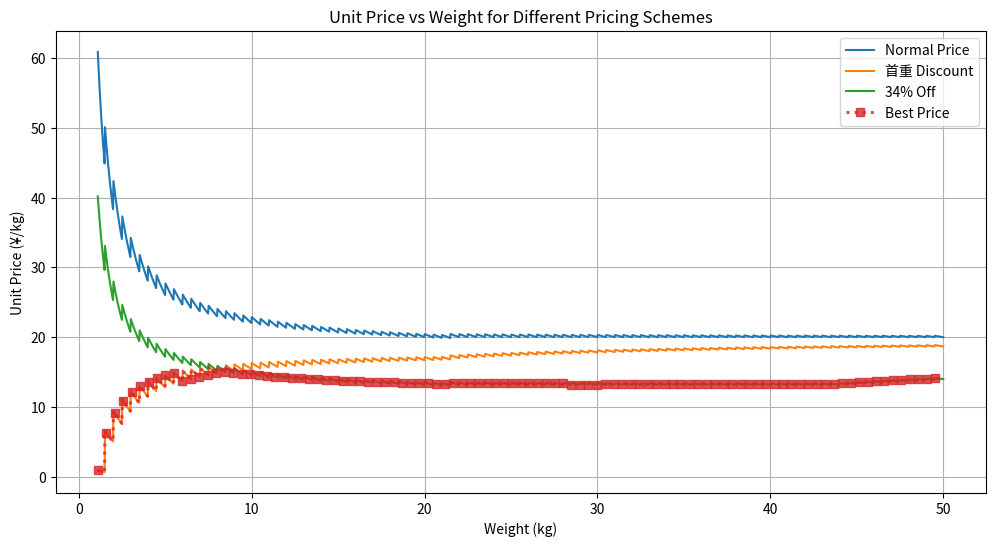

In [26]:
"""
Create a line plot, x axis = weight, y axis = unit price. 
There are 3 lines, one for normal price, one for 首重 discount, one for 34% off
"""
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['Source Han Sans CN', 'Droid Sans Fallback']
plt.rcParams['axes.unicode_minus'] = False     # Ensure minus signs display correctly

weights = np.linspace(1.1, 50, 2000)
normal_prices = [calculate_price(w)/w for w in weights]
discount_prices = [discount首重(w)/w for w in weights]
discount34_prices = [discount34_off(w)/w for w in weights]
best_prices = [min(normal_prices[i], discount_prices[i], discount34_prices[i]) for i in range(len(weights))]

plt.figure(figsize=(12,6))
plt.plot(weights, normal_prices, label='Normal Price')
plt.plot(weights, discount_prices, label='首重 Discount') 
plt.plot(weights, discount34_prices, label='34% Off')
plt.plot(weights, best_prices, label='Best Price', linestyle=':', marker='s', markevery=20, alpha=0.8, linewidth=2.2)
plt.xlabel('Weight (kg)')
plt.ylabel('Unit Price (¥/kg)')
plt.title('Unit Price vs Weight for Different Pricing Schemes')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
"""
Find the intersection point of 首重 discount and 34% off
"""
from scipy.optimize import fsolve

def price_diff(w):
    return discount首重(w)/w - discount34_off(w)/w

# Find weight where price difference is 0
intersection_weight = fsolve(price_diff, 1.2)[0]

print(f"Intersection point: {intersection_weight:.2f}kg")
print(f"Unit price at intersection: {discount首重(intersection_weight)/intersection_weight:.2f}¥/kg")

Intersection point: 8.50kg
Unit price at intersection: 14.94¥/kg


/home/jxu/miniconda3/envs/ds/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# shipping cost, assuming nothing, so the program will try to fit the goods into the cheapest config that uses discounts

In [3]:

def process_combination(args: tuple) -> Tuple[float, List]:
    """Process a single combination of goods with discounts"""
    k, remaining_goods, remaining_discounts, current_split, current_cost, best_cost = args
    
    current_package = GoodList(remaining_goods[:k])
    if current_package.total_final_weight > 65:
        return best_cost, []
        
    next_remaining = GoodList(remaining_goods[k:])
    local_best_cost, local_best_split = best_cost, []
    
    # Try all discount combinations (including no discount)
    discount_options = [("no discount", calculate_price, {})] + [
        (d_type, discount_functions[d_type], {d_type: count-1})
        for d_type, count in remaining_discounts.items()
        if count > 0
    ]
    
    for discount_type, price_func, new_discounts in discount_options:
        cost = price_func(current_package.total_final_weight)
        new_best_cost, new_split = try_combinations(
            next_remaining,
            {**remaining_discounts, **new_discounts},
            current_split + [(current_package, discount_type, cost)],
            current_cost + cost,
            local_best_cost,
        )
        if new_best_cost < local_best_cost:
            local_best_cost, local_best_split = new_best_cost, new_split
            
    return local_best_cost, local_best_split

def try_combinations(remaining_goods: GoodList, 
                    remaining_discounts: Dict[str, int],
                    current_split: List[Tuple[GoodList, str, float]],
                    current_cost: float,
                    best_cost: float,
                    pbar: tqdm = None,
                    pool: ProcessPoolExecutor = None) -> Tuple[float, List]:
    """Helper function to try different combinations of goods and discounts"""
    if current_cost >= best_cost or not remaining_goods:
        return (current_cost, current_split.copy()) if current_cost < best_cost else (best_cost, [])
    
    best_split = []
    is_top_level = pool and len(current_split) == 0 and pbar
    
    if is_top_level:
        # Create args for each combination
        args_list = [
            (k, remaining_goods, remaining_discounts, current_split, current_cost, best_cost)
            for k in range(1, len(remaining_goods) + 1)
        ]
        
        futures = [pool.submit(process_combination, args) for args in args_list]
        
        for future in as_completed(futures):
            pbar.update(1)
            new_best_cost, new_split = future.result()
            if new_best_cost < best_cost:
                best_cost, best_split = new_best_cost, new_split
                pbar.set_description(f"Current best: {best_cost:.2f}")
    else:
        for k in range(1, len(remaining_goods) + 1):
            args = (k, remaining_goods, remaining_discounts, current_split, current_cost, best_cost)
            new_best_cost, new_split = process_combination(args)
            if new_best_cost < best_cost:
                best_cost, best_split = new_best_cost, new_split
    
    return best_cost, best_split

def find_best_combination(goods: GoodList, available_discounts: Dict[str, int]):
    """
    Find the best shipping price of goods by applying the available discounts
    You should find the cheapest way to ship all the goods, and take advantage of the available discounts if you can
    E.g. if available_discounts = ["首重", "首重", "34off"], you can choose to use 2 "首重" and 1 "34off"
    You are allowed to not use all the available discounts as long as it's cheaper
    The function will print out the best combination and the total price, there will be a table with the following columns:
    - Package #
    - Goods
    - Weight (kg), this is the total weight of the goods in this package
    - Price (¥), this is the total price of the goods in this package
    - ¥/kg, this is the unit price of the total shipping price
    - ¥/item, this is the rough price for the good, total_price / goods.num_individal_goods
    - Discount, this is the discount type used, or "no discount" if no discount is used
    
    Algorithm:
    1. Sort goods by weight in descending order for better pruning opportunities
    
    2. Recursive combination approach with parallel processing:
        - For each possible subset size k of remaining goods:
            a. Try taking the first k items as a package
            b. Recursively process the remaining goods
            c. For each package, try:
                - No discount
                - Each available discount type
            d. Prune combinations if:
                - Package weight > 65kg
                - Current cost >= best known cost
    
    3. Use ProcessPoolExecutor for parallel processing at the top level:
        - Split work into independent tasks for each initial combination
        - Use tqdm for progress tracking
        - Maintain global best cost across all workers
    
    Time Complexity: O(2^n * d) where:
    - n is number of goods
    - d is number of available discount combinations
    
    Space Complexity: O(n) for recursion stack
    
    Note: Uses parallel processing and aggressive pruning to handle the exponential complexity.
    The implementation prioritizes finding good solutions quickly over guaranteeing the absolute optimal solution.
    """
    # Sort goods by weight for better pruning
    sorted_goods = GoodList(sorted(goods, key=lambda x: x.final_weight, reverse=True))
    
    # Calculate total number of combinations we'll try
    # This is a rough estimate: for each good, we try combining it with all possible subsequent goods
    total_combinations = sum(len(sorted_goods) - i for i in range(len(sorted_goods)))
    
    with ProcessPoolExecutor() as pool, tqdm(total=total_combinations, desc="Finding best combination") as pbar:
        best_cost, best_result = try_combinations(
            sorted_goods,
            available_discounts,
            current_split=[], 
            current_cost=0,
            best_cost=float('inf'),
            pbar=pbar,
            pool=pool
        )
    
    if not best_result:
        raise ValueError("No valid solution found")
    
    not_used_discounts = available_discounts.copy()
    for goods, discount_type, cost in best_result:
        if discount_type != "no discount":
            not_used_discounts[discount_type] -= 1
    # Headers
    headers = ["Package #", "Goods", "Weight (kg)", "Price (¥)", "¥/kg", "¥/item", "Discount"]
    
    # Prepare rows
    rows = []
    for i, (goods, discount_type, cost) in enumerate(best_result, 1):
        rows.append([
                i,
                str(goods),
                f"{goods.total_final_weight:.2f}",
                f"{cost:.2f}",
                f"{cost / goods.total_final_weight:.2f}",
                f"{cost / goods.num_individal_goods:.2f}",
                discount_type
            ])
    
    # Add total row
    rows.append([
        "Total",
        f"({len(best_result)} packages)",
        f"{sorted_goods.total_final_weight:.2f}",
        f"{best_cost:.2f}",
        f"{best_cost / sorted_goods.total_final_weight:.2f}",
        f"{best_cost / sorted_goods.num_individal_goods:.2f}",
        f"Unused: {dict(not_used_discounts)}"
    ])
    
    # Create table
    from pytablewriter import MarkdownTableWriter
    writer = MarkdownTableWriter(
        headers=headers,
        value_matrix=rows,
        margin=1
    )
    writer.write_table()

# shipping cost, assuming that the weight threshold is determined

In [4]:
def process_r_combinations(r: int, sorted_goods: List[Good], max_weight_limit: KG) -> Tuple[KG, List[Good]]:
    """
    Process all combinations of length r
    However, this is very slow to calculate all combinations (complexity is O(n^r))
    But since this is a variant of knapsack problem, use some heuristics to speed up
    Assume `sorted_goods` is sorted by final_weight, from heavy to light
    """
    best_weight = 0.0
    best_combo = None
    # early stoppping: if sum of r lightest goods is already larger than max_weight_limit, no need to calculate further
    lightest_r_sum = sum(good.final_weight for good in sorted_goods[-r:])
    if lightest_r_sum > max_weight_limit:
        return best_weight, best_combo
    # early stopping: if sum of r heaviest goods is already smaller than max_weight_limit, no need to calculate further
    heaviest_r_sum = sum(good.final_weight for good in sorted_goods[:r])
    if heaviest_r_sum <= max_weight_limit:
        return heaviest_r_sum, sorted_goods[:r]
    
    for combo in combinations(sorted_goods, r):
        total_weight = sum(good.final_weight for good in combo)
        if total_weight <= max_weight_limit and total_weight > best_weight:
            best_weight = total_weight
            best_combo = list(combo)  # Convert to list to avoid GoodList pickling
            
    return best_weight, best_combo

# Function to calculate the best combination
def max_final_weight_under_limit(goods: GoodList, max_weight_limit: KG) -> Tuple[KG, GoodList]:
    """
    Calculate the maximum final weight that is under the given limit.
    Also return the combination of goods that achieve this maximum weight.
    """
    best_weight = 0.0
    best_combo = GoodList()
    
    sorted_goods = sorted(goods, key=lambda x: x.final_weight, reverse=True)
    
    with ProcessPoolExecutor(max_workers=len(sorted_goods)) as executor:
        # Submit tasks for each r
        future_to_r = {
            executor.submit(process_r_combinations, r, sorted_goods, max_weight_limit): r 
            for r in range(1, len(sorted_goods) + 1)
        }
        
        # Process results as they complete
        for future in as_completed(future_to_r):
            weight, combo = future.result()
            if combo is not None and weight > best_weight:
                best_weight = weight
                best_combo = GoodList(combo)
    
    return best_weight, best_combo

def max_final_weight_under_threasholds(goods: GoodList, max_weight_thresholds: List[KG]) -> Dict[KG, Tuple[KG, GoodList]]:
    """
    Compare to max_final_weight_under_limit, it will try to fit the goods into each threshold and return the best result
    E.g. if thresholds = [44, 44, 9.5]
    it will find the best combination under 44kg, and then for the remaining, find the best combination under 44kg, and then for the remaining, find the best combination under 9.5kg, then whatever is the leftover will be returned
    the result will be a dict like this:
    {
       1.44: (the kg of the result comb, comb), # 1.44 since this is the first threshold, the value is 44
       2.44: (the kg of the result comb, comb), # 2.44 since this is the second threshold, the value is 44
       3.9.5: (the kg of the result comb, comb) # 3.9.5 since this is the third threshold, the value is 9.5
       4.remaining: (the kg of the result comb, comb) # the remaining goods
    }
    """
    remaining_goods = GoodList(goods)  # Create a copy of the input goods
    result = {}
    
    # Process each threshold with an index
    for i, threshold in enumerate(max_weight_thresholds, 1):
        print(f"Processing threshold {i}.{threshold}, remaining {len(remaining_goods)} goods")
        if not remaining_goods:  # If no goods left, break
            break
            
        # Find best combination under current threshold
        weight, combination = max_final_weight_under_limit(remaining_goods, threshold)
        
        if combination:  # If we found a valid combination
            print(f"Found a valid combination: {combination} ({weight}kg)")
            # Remove the used goods from remaining_goods
            for good in combination:
                remaining_goods.remove(good)
            
            # Add results to our dict with threshold key
            result[f"{i}.{threshold}"] = (weight, combination)
    
    # Add any remaining goods as the last combination if there are any
    if remaining_goods:
        total_weight = sum(good.final_weight for good in remaining_goods)
        result[f"{len(max_weight_thresholds)+1}.remaining"] = (total_weight, remaining_goods)
    
    return result

# Put this in practice

In [4]:
# each element in the list is a shipping
# a shipping is a 2-tuple
# first is GoodList
# second is the price paid, after different coupon and discount
cainiao_shipping = [
    # cc
    [
        GoodList([
            Good("核能矩阵巅狼", 1.839, 44, 33, 17),
            Good("DUCK黑武士", 2.963, 52, 36, 22),
            Good("月夜审判", 2.4, 47, 36, 24),
            Good("酸浆果", 3.15, 45, 20, 36),
            Good("星恒", 2.469, 49, 33, 20),
            Good("奥伯龙", 2.574, 39, 29, 21),
        ]),
        429
    ],
    [
        GoodList([
            Good("兔子月", 1.432, 35, 19, 15),
        ]),
        10
    ],
    [
        GoodList([
            Good("陆战铁球", 0.804, 36, 22, 12),
        ]),
        10
    ],
    [
        GoodList([
            Good("大林 地台", 0.85, 40, 24, 9),
        ]),
        1
    ],
    [
        GoodList([
            Good("喵匠 地台", 0.557, 24, 24, 11),
            Good("ew 德天使支架", 0.487, 32, 21, 7),
        ]),
        10
    ],
    [
        GoodList([
            Good("EW 福冈牛", 0.419, 33, 26, 5),
            Good("水贴分离工具", 0.381, 24, 15, 5),
            Good("迪斯派陶瓷矬子", 0.375, 17, 12, 9),
        ]),
        1
    ],
    [
        GoodList([
            Good("boy 眼睛", 0.277, 19, 11, 9),
            Good("抛光块", 0.073, 17, 16, 6),
            Good("平底钻 多个", 0.155, 21, 13, 5),
        ]),
        8
    ],
    [
        GoodList([
            Good("RG 海牛 地台 + 月光蝶", 0.65, 31, 22, 13, num_good_in_package=2),
        ]),
        1
    ],
    [
        GoodList([
            Good("防割指套", 0.07, 19, 4, 4),
            Good("蓝丁胶", 0.219, 18, 14, 1),
            Good("蚀刻片", 0.039, 16, 10, 4),
            Good("眼影笔刷", 0.077, 22, 16, 2),
            Good("神之手海绵砂纸2包", 0.073, 14, 10, 9, num_good_in_package=2),
            Good("MGSD 自由地台", 0.206, 18, 13, 5),
            Good("关节笔 3个", 0.039, 16, 11, 2),
        ]),
        0.3
    ],
    [
        GoodList([
            Good("CCS 刚巴斯塔", 6.15, 61, 40, 32),
            Good("武成+天未+梵天", 8.15, 51, 35, 45, num_good_in_package=3),
        ]),
        349.8
    ],
    [
        GoodList([
            Good("将魂姬猫女", 1.366, 41, 30, 12),
            Good("EW 海牛粒子炮", 1.035, 38, 29, 14),
            Good("boy 三脚架", 1.85, 64, 17, 14),
            Good("EW HWS", 0.782, 35, 26, 12),
            Good("EW 沙扎比背包+蟹钳+地台", 1.859, 33, 31, 22, num_good_in_package=3),
            Good("透明铁球", 0.912, 39, 30, 12),
        ]),
        210.54
    ],
    # my account
    [
        GoodList([
            Good("破晓", 1.933, 40, 28, 13),
            Good("铁创 00R+00Q 铁骨", 1.003, 28, 21, 13, num_good_in_package=2),
            Good("ray工具一堆", 0.669, 22, 16, 16),
            Good("CCS 魔神SKL", 5.25, 57, 48, 23),
            Good("超模力", 1.75, 40, 30, 16),
            Good("威远+塔式提尔+多鲁翅膀+曙光+雷霆", 11.3, 76, 46, 40, num_good_in_package=5), # CCS 7件 7884615490887
            Good("威远剑", 1.36, 39, 28, 13), # 摩动核两件 434206643573099
        ]),
        580.8
    ],
    [
        GoodList([
            Good("无限新星ruling+先驱+湖中骑士", 8.35, 69, 40, 35, num_good_in_package=3), # 藏道6件 773317977460726
            Good("天幕", 5.75, 65, 43, 27),
        ]),
        382.8
    ],
    [
        GoodList([
            Good("震荡波", 3.666, 50, 36, 28),
            Good("冰霜猫", 3.65, 54, 41, 24),
            Good("touchtoys 2个", 4.095, 48, 31, 33, num_good_in_package=2),
        ]),
        336.6
    ],
    [
        GoodList([
            Good("贪婪 休眠仓", 1.123, 30, 26, 15),
        ]),
        10
    ],
    [
        GoodList([
            Good("哪吒", 2.75, 51, 38, 17),
            Good("卡戎", 2.206, 41, 36, 21),
            Good("武皇", 3.004, 42, 34, 19),
            Good("白起", 2.45, 49, 35, 15), # CCS Toys 摩动核 2件 78846240591697
            Good("ZZA", 2.65, 41, 34, 18),
            Good("曹仁", 2.152, 49, 35, 1/3),
            Good("三脚架", 2.071, 62, 18, 14),
        ]),
        396
    ],
    [
        GoodList([
            Good("EW Z 粒子炮 + EW 牛地台", 1.114, 28, 24, 17, num_good_in_package=2),
        ]),
        10
    ],
    [
        GoodList([
            Good("玄武", 4.75, 49, 40, 25),
            Good("天启", 3.8, 43, 37, 26),
            Good("贪婪", 4.2, 56, 38, 23),
            Good("刃皇", 2.45, 42, 36, 22),
        ]),
        382.8
    ],
    [
        GoodList([
            Good("玻璃钳子", 0.291, 23, 15, 3),
            Good("ew癌变", 0.306, 30, 18, 7),
            Good("铁创 Exia", 0.598, 27, 20, 7),
            Good("cfa 读卡器", 0.175, 15, 11, 4),
            Good("JJC相机", 0.149, 17, 10, 10),
        ]),
        10
    ],
    [
        GoodList([
            Good("awka滑雪服", 0.886, 50, 43, 5),
        ]),
        10
    ],
    [
        GoodList([
            Good("云雀", 0.668, 36, 23, 13),
        ]),
        10
    ],
    [
        GoodList([
            Good("扎罗夫", 0.688, 36, 24, 14),
        ]),
        10
    ],
    [
        GoodList([
            Good("Ray毛刷", 0.173, 23, 13, 4), 
            Good("拼图", 1.203, 40, 25, 7),
        ]),
        1
    ],
    [
        GoodList([
            Good("MB支架 x 2", 1.49, 34, 27, 21),
            Good("魂支架 x 10", 0.213, 24, 16, 4),
        ]),
        45
    ],
    [
        GoodList([
            Good("na爵士", 0.143, 15, 11, 10),
            Good("md 001", 2.718, 41, 35, 19),
            Good("机械入侵B套装", 1.57, 28, 28, 18),
            Good("铁工厂禁闭", 0.372, 25, 20, 12),
            Good("铁工厂钢索", 0.551, 30, 24, 14)
        ]),
        198
    ],
    # [
    #     GoodList([
    #         Good("DA100", 0, 62, 41, 30),
    #         Good("fanshobby E擎天柱+海洋堂艾伦+孤影+希切尔", 0, 64, 46, 33),
    #     ]),
    #     580 + 100
    # ]
]

all_goodlists = GoodList([])
for ele in cainiao_shipping:
    all_goodlists.extend(ele[0])
all_goodlists.pprint()

--------------------------------------------------
Total 90 goods in 75 packages, weight 267.1239999999999 (actual weight 140.37200000000004)
关节笔 3个: 0.06kg
防割指套: 0.07kg
蚀刻片: 0.11kg
眼影笔刷: 0.12kg
cfa 读卡器: 0.17kg
Ray毛刷: 0.20kg
MGSD 自由地台: 0.21kg
神之手海绵砂纸2包: 0.21kg
蓝丁胶: 0.22kg
平底钻 多个: 0.23kg
魂支架 x 10: 0.26kg
抛光块: 0.27kg
na爵士: 0.28kg
JJC相机: 0.28kg
玻璃钳子: 0.29kg
boy 眼睛: 0.31kg
迪斯派陶瓷矬子: 0.38kg
水贴分离工具: 0.38kg
ew癌变: 0.63kg
铁创 Exia: 0.63kg
EW 福冈牛: 0.71kg
ew 德天使支架: 0.78kg
ray工具一堆: 0.94kg
铁工厂禁闭: 1.00kg
喵匠 地台: 1.06kg
拼图: 1.20kg
铁创 00R+00Q 铁骨: 1.27kg
大林 地台: 1.44kg
RG 海牛 地台 + 月光蝶: 1.48kg
陆战铁球: 1.58kg
兔子月: 1.66kg
铁工厂钢索: 1.68kg
awka滑雪服: 1.79kg
云雀: 1.79kg
EW HWS: 1.82kg
EW Z 粒子炮 + EW 牛地台: 1.90kg
贪婪 休眠仓: 1.95kg
扎罗夫: 2.02kg
曹仁: 2.15kg
透明铁球: 2.34kg
机械入侵B套装: 2.35kg
威远剑: 2.37kg
破晓: 2.43kg
将魂姬猫女: 2.46kg
boy 三脚架: 2.54kg
EW 海牛粒子炮: 2.57kg
三脚架: 2.60kg
超模力: 3.20kg
MB支架 x 2: 3.21kg
EW 沙扎比背包+蟹钳+地台: 3.75kg
奥伯龙: 3.96kg
核能矩阵巅狼: 4.11kg
ZZA: 4.18kg
白起: 4.29kg
武皇: 4.52kg
md 001: 4.54kg
卡戎: 5.17kg
星恒: 5.39kg
酸浆果: 5.40kg
哪吒: 

In [9]:
"""
Use pytablewriter to generate a table with columns:
- shipping ID
- items
- Total number of items
- Price in RMB
- Price/kg in RMB
- Price/item in RMB

Where shipping ID is the index of the shipping list (eg #1, #2, etc.).
And finally add a row of average, where total number of items is the sum of all previous, and price is the sum of all previous, and per kg and per item is average
"""
# Prepare rows
rows = []
total_items = 0
total_price = 0
total_weight = 0

for i, (goods, price) in enumerate(cainiao_shipping, 1):
    num_items = goods.num_individal_goods
    weight = goods.total_final_weight
    
    total_items += num_items
    total_price += price
    total_weight += weight
    
    rows.append([
        f"#{i}",
        ",".join([g.name for g in goods]),
        num_items,
        f"{price:.2f}",
        f"{price/weight:.2f}",
        f"{price/num_items:.2f}"
    ])

# Add average/total row
rows.append([
    "Total/Avg",
    "--",
    total_items,
    f"{total_price:.2f}",
    f"{total_price/total_weight:.2f}",
    f"{total_price/total_items:.2f}"
])

# Create and write table
writer = MarkdownTableWriter(
    headers=["Shipping ID", "Items", "Total Items", "Price (¥)", "¥/kg", "¥/item"],
    value_matrix=rows,
    margin=1
)
display(Markdown(writer.dumps()))

| Shipping ID |                                             Items                                             | Total Items | Price (¥) | ¥/kg  | ¥/item |
| ----------- | --------------------------------------------------------------------------------------------- | ----------: | --------: | ----: | -----: |
| #1          | 核能矩阵巅狼,DUCK黑武士,月夜审判,酸浆果,星恒,奥伯龙                                           |           6 |    429.00 | 13.20 |  71.50 |
| #2          | 兔子月                                                                                        |           1 |     10.00 |  6.02 |  10.00 |
| #3          | 陆战铁球                                                                                      |           1 |     10.00 |  6.31 |  10.00 |
| #4          | 大林 地台                                                                                     |           1 |      1.00 |  0.69 |   1.00 |
| #5          | 喵匠 地台,ew 德天使支架                                                                       |           2 |     10.00 |  5.43 |   5.00 |
| #6          | EW 福冈牛,水贴分离工具,迪斯派陶瓷矬子                                                         |           3 |      1.00 |  0.68 |   0.33 |
| #7          | boy 眼睛,抛光块,平底钻 多个                                                                   |           3 |      8.00 |  9.84 |   2.67 |
| #8          | RG 海牛 地台 + 月光蝶                                                                         |           2 |      1.00 |  0.68 |   0.50 |
| #9          | 防割指套,蓝丁胶,蚀刻片,眼影笔刷,神之手海绵砂纸2包,MGSD 自由地台,关节笔 3个                    |           8 |      0.30 |  0.30 |   0.04 |
| #10         | CCS 刚巴斯塔,武成+天未+梵天                                                                   |           4 |    349.80 | 13.25 |  87.45 |
| #11         | 将魂姬猫女,EW 海牛粒子炮,boy 三脚架,EW HWS,EW 沙扎比背包+蟹钳+地台,透明铁球                   |           8 |    210.54 | 13.60 |  26.32 |
| #12         | 破晓,铁创 00R+00Q 铁骨,ray工具一堆,CCS 魔神SKL,超模力,威远+塔式提尔+多鲁翅膀+曙光+雷霆,威远剑 |          12 |    580.80 | 13.20 |  48.40 |
| #13         | 无限新星ruling+先驱+湖中骑士,天幕                                                             |           4 |    382.80 | 13.35 |  95.70 |
| #14         | 震荡波,冰霜猫,touchtoys 2个                                                                   |           4 |    336.60 | 13.23 |  84.15 |
| #15         | 贪婪 休眠仓                                                                                   |           1 |     10.00 |  5.13 |  10.00 |
| #16         | 哪吒,卡戎,武皇,白起,ZZA,曹仁,三脚架                                                           |           7 |    396.00 | 13.94 |  56.57 |
| #17         | EW Z 粒子炮 + EW 牛地台                                                                       |           2 |     10.00 |  5.25 |   5.00 |
| #18         | 玄武,天启,贪婪,刃皇                                                                           |           4 |    382.80 | 13.31 |  95.70 |
| #19         | 玻璃钳子,ew癌变,铁创 Exia,cfa 读卡器,JJC相机                                                  |           5 |     10.00 |  4.98 |   2.00 |
| #20         | awka滑雪服                                                                                    |           1 |     10.00 |  5.58 |  10.00 |
| #21         | 云雀                                                                                          |           1 |     10.00 |  5.57 |  10.00 |
| #22         | 扎罗夫                                                                                        |           1 |     10.00 |  4.96 |  10.00 |
| #23         | Ray毛刷,拼图                                                                                  |           2 |      1.00 |  0.71 |   0.50 |
| #24         | MB支架 x 2,魂支架 x 10                                                                        |           2 |     45.00 | 12.97 |  22.50 |
| #25         | na爵士,md 001,机械入侵B套装,铁工厂禁闭,铁工厂钢索                                             |           5 |    198.00 | 20.10 |  39.60 |
| Total/Avg   | --                                                                                            |          90 |   3413.64 | 12.78 |  37.93 |


In [5]:
discounts = {"10off": 1, "满200减20": 1, "无门槛15": 2}
find_best_combination(cainiao_goods, discounts)

Current best: 157.50:  50%|█████     | 3/6 [00:00<00:00, 51.69it/s]

| Package # |              Goods              | Weight (kg) | Price (¥) | ¥/kg  | ¥/item |                      Discount                       |
| --------- | ------------------------------- | ----------: | --------: | ----: | -----: | --------------------------------------------------- |
|         1 | [md 001, 机械入侵B套装, na爵士] |        7.17 |     157.5 | 21.96 |   52.5 | 10off                                               |
| Total     | (1 packages)                    |        7.17 |     157.5 | 21.96 |   52.5 | Unused: {'10off': 0, '满200减20': 1, '无门槛15': 2} |


| Package # |                            Goods                            | Weight (kg) | Price (¥) | ¥/kg  | ¥/item |            Discount             |
| --------- | ----------------------------------------------------------- | ----------: | --------: | ----: | -----: | ------------------------------- |
|         1 | [无限新星ruling+先驱+湖中骑士, 天幕]                        |       28.68 |     382.8 | 13.35 |  95.70 | 34off                           |
|         2 | [冰霜猫, 震荡波, touchtoys 2个]                             |       25.44 |     336.6 | 13.23 |  84.15 | 34off                           |
|         3 | [玄武, 贪婪, 天启, 刃皇]                                    |       28.76 |     382.8 | 13.31 |  95.70 | 34off                           |
|         4 | [哪吒, 卡戎, 武皇, 白起, ZZA, 曹仁, 三脚架]                 |       29.97 |     396.0 | 13.21 |  56.57 | 34off                           |
|         5 | [扎罗夫]                                                    |        2.02 |      19.0 |  9.42 |  19.00 | 首重                            |
|         6 | [贪婪 休眠仓]                                               |        1.95 |      10.0 |  5.13 |  10.00 | 首重                            |
|         7 | [EW Z 粒子炮 + EW 牛地台]                                   |        1.90 |      10.0 |  5.25 |   5.00 | 首重                            |
|         8 | [云雀]                                                      |        1.79 |      10.0 |  5.57 |  10.00 | 首重                            |
|         9 | [awka滑雪服]                                                |        1.79 |      10.0 |  5.58 |  10.00 | 首重                            |
|        10 | [拼图]                                                      |        1.20 |       1.0 |  0.83 |   1.00 | 首重                            |
|        11 | [ew癌变, 铁创 Exia, 玻璃钳子, JJC相机, Ray毛刷, cfa 读卡器] |        2.21 |      19.0 |  8.60 |   3.17 | 首重                            |
| Total     | (11 packages)                                               |      125.72 |    1577.2 | 12.55 |  49.29 | Unused: {'首重': 0, '34off': 1} |

| Package # |                                             Goods                                             | Weight (kg) | Price (¥) | ¥/kg  | ¥/item |                    Discount                    |
| --------- | --------------------------------------------------------------------------------------------- | ----------: | --------: | ----: | -----: | ---------------------------------------------- |
|         1 | [武成+天未+梵天, CCS 刚巴斯塔]                                                                |       26.40 |    349.80 | 13.25 |  87.45 | 34off                                          |
|         2 | [DUCK黑武士, 月夜审判, 酸浆果, 星恒, 核能矩阵巅狼, 奥伯龙]                                    |       32.49 |    429.00 | 13.20 |  71.50 | 34off                                          |
|         3 | [EW 沙扎比背包+蟹钳+地台, EW 海牛粒子炮, boy 三脚架, 将魂姬猫女, 透明铁球, EW HWS]            |       15.48 |    210.54 | 13.60 |  26.32 | 34off                                          |
|         4 | [兔子月]                                                                                      |        1.66 |     10.00 |  6.02 |  10.00 | 首重                                           |
|         5 | [陆战铁球]                                                                                    |        1.58 |     10.00 |  6.31 |  10.00 | 首重                                           |
|         6 | [RG 海牛 地台 + 月光蝶]                                                                       |        1.48 |      1.00 |  0.68 |   0.50 | 首重                                           |
|         7 | [大林 地台]                                                                                   |        1.44 |      1.00 |  0.69 |   1.00 | 首重                                           |
|         8 | [喵匠 地台]                                                                                   |        1.06 |      1.00 |  0.95 |   1.00 | 首重                                           |
|         9 | [ew 德天使支架, EW 福冈牛]                                                                    |        1.50 |      1.00 |  0.67 |   0.50 | 首重                                           |
|        10 | [水贴分离工具, 迪斯派陶瓷矬子, boy 眼睛]                                                      |        1.07 |      1.00 |  0.94 |   0.33 | 首重                                           |
|        11 | [抛光块, 平底钻 多个, 蓝丁胶, 神之手海绵砂纸2包, MGSD 自由地台, 眼影笔刷, 蚀刻片, 关节笔 3个] |        1.42 |      1.00 |  0.71 |   0.11 | 首重                                           |
| Total     | (11 packages)                                                                                 |       85.58 |   1015.34 | 11.86 |  26.72 | Unused: {'首重': 0, '34off': 2, '无门槛50': 1} |

In [11]:
max_final_weight_under_limit(my_goods, 44)

(44.0, [ruling+先驱+湖中骑士, 天幕, 刃皇, 哪吒, 白起])

In [15]:
d = max_final_weight_under_threasholds(my_goods, [1.5, 1.5, 1.5, 1.5, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.5, 6.0, 44, 44, 44]) # should be 44.5? 这样🈴包还给
pprint(d)

Processing threshold 1.1.5, remaining 26 goods
Found a valid combination: [拼图, JJC相机] (1.4863333333333335kg)
Processing threshold 2.1.5, remaining 24 goods
Found a valid combination: [ew癌变, 铁创 Exia, cfa 读卡器] (1.435kg)
Processing threshold 3.1.5, remaining 21 goods
Processing threshold 4.1.5, remaining 21 goods
Processing threshold 5.1.5, remaining 21 goods
Processing threshold 6.2.0, remaining 21 goods
Found a valid combination: [贪婪 休眠仓] (1.95kg)
Processing threshold 7.2.5, remaining 20 goods
Found a valid combination: [扎罗夫] (2.016kg)
Processing threshold 8.3.0, remaining 19 goods
Found a valid combination: [三脚架] (2.604kg)
Processing threshold 9.3.5, remaining 18 goods
Found a valid combination: [EW Z 粒子炮 + EW 牛地台] (1.904kg)
Processing threshold 10.4.0, remaining 17 goods
Found a valid combination: [曹仁] (3.7158333333333333kg)
Processing threshold 11.5.5, remaining 16 goods
Found a valid combination: [哪吒] (5.491kg)
Processing threshold 12.6.0, remaining 15 goods
Found a valid combinatio